In [1]:
from nn_generalisation import neural_net
from nn_generalisation.experiment import Experiment, setup_log_path
from nn_generalisation.data import logging_utils
from nn_generalisation.landscape_analysis.utils import cat_and_flatten
import torch
from torch.utils.data import DataLoader
from torch.nn import MSELoss
from torch import optim
from tqdm import tqdm, trange
import logging
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def train_and_return_grad(model : neural_net.DenseNN,
          train_loader : DataLoader,
          optimizer : torch.optim.SGD,
          loss_fn : torch.nn.modules.loss._Loss | torch.nn.modules.loss._WeightedLoss,
          args : dict) -> tuple[float]:
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if not args["pre_transfer"]:
            data, target = data.to(args["device"]), target.to(args["device"])
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target) / len(data)
        epoch_loss += loss * len(data)
        loss.backward()
        grads = cat_and_flatten([-optimizer.param_groups[0]['lr'] * p.grad for p in model.parameters()])
        optimizer.step()
    return epoch_loss.item() / len(train_loader.dataset), grads

def test(model : neural_net.DenseNN,
        test_loader : DataLoader,
        loss_fn : torch.nn.modules.loss._Loss | torch.nn.modules.loss._WeightedLoss,
        args : dict) -> float:
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            if not args["pre_transfer"]:
                data, target = data.to(args["device"]), target.to(args["device"])
            output = model(data)
            test_loss += loss_fn(output, target)
    return test_loss.item() / len(test_loader.dataset)

def get_landscape_metrics(model : neural_net.DenseNN,
        test_loader : DataLoader,
        loss_fn : torch.nn.modules.loss._Loss | torch.nn.modules.loss._WeightedLoss,
        args : dict,
        v : torch.Tensor) -> tuple[float]:
    model.eval()
    model.zero_grad()
    test_loss = 0
    for data, target in test_loader:
        if not args["pre_transfer"]:
            data, target = data.to(args["device"]), target.to(args["device"])
        output = model(data)
        test_loss += loss_fn(output, target) / len(data)
    grad_params = torch.autograd.grad(test_loss, model.get_params(), create_graph=True)
    grad_params = torch.cat([g.view(-1) for g in grad_params])
    hv_product = torch.autograd.grad(grad_params, model.get_params(), grad_outputs=v, retain_graph=True)
    vhv_product = torch.dot(v, cat_and_flatten(hv_product))
    return torch.linalg.norm(grad_params).item(), vhv_product.item()

def train_model_to_steady_state(model : neural_net.DenseNN,
                train_loader : DataLoader,
                test_loader : DataLoader,
                args : dict,
                log_path : str) -> tuple[list[float], list[float]]:
    # Save model with initialised weights for testing equality of output
    logging_utils.save_model(model, f"{log_path + 'model_size_' + str(model.num_hidden_units)}_initial.pt")

    train_losses = []
    test_losses = []
    optimizer = optim.SGD(model.parameters(), lr=args["lr"], momentum=args["momentum"])
    if args["loss_fn"] == "mse":
        loss_fn = MSELoss(reduction="sum")
    else:
        raise Exception(f"Specified loss function '{args['loss_fn']}' was not valid. Options: 'mse'.")
    with trange(args["epochs"], desc=f"Model with {model.num_hidden_units} hidden units training progress") as pbar:
        for epoch in pbar:
            train_loss, grad = train_and_return_grad(model, train_loader, optimizer, loss_fn, args)
            test_loss = neural_net.test(model, test_loader, loss_fn, args)
            if epoch > 100 and train_losses[-100] - train_loss < 0.001 * train_losses[-100] and abs(test_losses[-100] - test_loss) < 0.001 * test_losses[-100]:
                break
            if epoch > 1:
                pbar.set_postfix_str(f"change in loss: {train_losses[-1] - train_loss}", refresh=True)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            logging.info(f"epoch: {epoch}, train: {train_loss:.16f}, test: {test_loss:.16f}")

    # Save model with final weights for testing equality of output
    logging_utils.save_model(model, f"{log_path + 'model_size_' + str(model.num_hidden_units)}_{epoch}_epochs.pt")
    return train_losses, test_losses#, grad

def train_model_and_get_landscape_metrics(model : neural_net.DenseNN,
                train_loader : DataLoader,
                test_loader : DataLoader,
                args : dict,
                log_path : str,
                landscape_interval : int) -> tuple[list[float], list[float]]:
    # Save model with initialised weights for testing equality of output
    logging_utils.save_model(model, f"{log_path + 'model_size_' + str(model.num_hidden_units)}_initial.pt")

    train_losses = []
    test_losses = []
    landscape_metrics = {}
    optimizer = optim.SGD(model.parameters(), lr=args["lr"], momentum=args["momentum"])
    if args["loss_fn"] == "mse":
        loss_fn = MSELoss(reduction="sum")
    else:
        raise Exception(f"Specified loss function '{args['loss_fn']}' was not valid. Options: 'mse'.")
    with trange(args["epochs"], desc=f"Model with {model.num_hidden_units} hidden units training progress") as pbar:
        for epoch in pbar:
            if epoch % landscape_interval == 0:
                train_loss, weight_updates = train_and_return_grad(model, train_loader, optimizer, loss_fn, args)
                test_loss = neural_net.test(model, test_loader, loss_fn, args)
                landscape_metrics[f"epoch_{epoch}"] = get_landscape_metrics(model, test_loader, loss_fn, args, weight_updates)
            else:
                train_loss = neural_net.train(model, train_loader, optimizer, loss_fn, args)
                test_loss = neural_net.test(model, test_loader, loss_fn, args)
            if epoch > 0:
                pbar.set_postfix_str(f"change in loss: {train_losses[-1] - train_loss}", refresh=True)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            logging.info(f"epoch: {epoch}, train: {train_loss:.16f}, test: {test_loss:.16f}")

    # Save model with final weights for testing equality of output
    logging_utils.save_model(model, f"{log_path + 'model_size_' + str(model.num_hidden_units)}_{epoch}_epochs.pt")
    return train_losses, test_losses, landscape_metrics

In [3]:
experiment_args = {
    "num_hidden_units": [55],
    "train_size": 4000,
    "batch_size": 64,
    "test_batch_size": 1000,
    "epochs": 1000,
    "lr": 0.001,
    "momentum": 0.95,
    "gamma": 0.9,
    "loss_fn": "mse",
    "param_reuse": True,
    "seed": 2,
    "data_seed": 2,
    "pre_transfer": True,
}

## Get starting model

In [5]:
# Code to get starting model
exp = Experiment(experiment_args)

model_20 = neural_net.DenseNN(20).to(exp.args["device"])
exp.log_path = setup_log_path(exp.datetime)
logging_utils.setup_log(f"{exp.log_path + 'training.log'}")
#_, _, grad = train_model_to_steady_state(model_20, exp.train_loader, exp.test_loader, experiment_args, exp.log_path)
exp.experiment_log[f"model_{model_20.num_hidden_units}"] = train_model_to_steady_state(model_20, exp.train_loader, exp.test_loader, experiment_args, exp.log_path)
exp.args.pop("device")
logging_utils.save_json(exp.experiment_log, f"{exp.log_path + 'experiment_log'}.json")

Model with 20 hidden units training progress:  19%|█▉        | 1143/6000 [03:17<13:59,  5.79it/s, change in loss: -0.0017730484008789127] 


## Get landscape metrics of larger models

In [38]:
# Code to get landscape metrics for models initialised with transformation of starting model weights

for num_hidden_units in [*range(20, 150, 5)]:
    exp = Experiment(experiment_args)

    start_model = logging_utils.load_model(20, r"./log/seed2/start_model/model_size_20_1143_epochs.pt").to(exp.args["device"])
    model = neural_net.DenseNN(num_hidden_units).to(exp.args["device"])
    model.set_params(neural_net.extend_params(start_model.get_params(), num_hidden_units, exp.args["device"]))

    exp.log_path = setup_log_path(exp.datetime)
    logging_utils.setup_log(f"{exp.log_path + 'training.log'}")
    exp.experiment_log[f"model_{model.num_hidden_units}"] = train_model_and_get_landscape_metrics(model, exp.train_loader, exp.test_loader, experiment_args, exp.log_path, 10)
    exp.args.pop("device")
    logging_utils.save_json(exp.experiment_log, f"{exp.log_path + 'experiment_log'}.json")

Model with 145 hidden units training progress: 100%|██████████| 1000/1000 [03:00<00:00,  5.53it/s, change in loss: 0.00014707803726196275]


## Analysis of slope/curvature

In [4]:
def sattr(d, *attrs):
    # Adds "val" to dict in the hierarchy mentioned via *attrs
    for attr in attrs[:-2]:
        # If such key is not found or the value is primitive supply an empty dict
        if d.get(attr) is None or not isinstance(d.get(attr), dict):
            d[attr] = {}
        d = d[attr]
    d[attrs[-2]] = attrs[-1]

In [5]:
landscape_metric_store = {}
loss_metrics = {}
start_paths = ["./log/seed2/seed1_larger_models/",
               "./log/seed2/seed2_larger_models/"]
            #    "./log/seed1/seed3_larger_models/",
            #    "./log/seed1/seed4_larger_models/",
            #    "./log/seed1/seed5_larger_models/",
            #    "./log/seed1/seed6_larger_models/",
            #    "./log/seed1/seed7_larger_models/",
            #    "./log/seed1/seed8_larger_models/",
            #    "./log/seed1/seed9_larger_models/"]
for start_path in start_paths:
    for path, dirs, files in os.walk(start_path):
        for file in files:
            if "experiment_log" in file:
                exp_log = logging_utils.load_json("/".join([path,file]))
                for key, value in exp_log.items():
                    if key.startswith("model_"):
                        num_hidden_units = int(key.split("_")[-1])
                        slope = []
                        curvature = []
                        for _, (slope_val, curvature_val) in value[2].items():
                            slope.append(slope_val)
                            curvature.append(curvature_val)
                        slope = np.array(slope)
                        curvature = np.array(curvature)
                        if key in landscape_metric_store:
                            landscape_metric_store[key]["slope"] += slope
                            landscape_metric_store[key]["curvature"] += curvature
                        else:
                            sattr(landscape_metric_store, key, "slope", slope)
                            sattr(landscape_metric_store, key, "curvature", curvature)
                        if key in loss_metrics:
                            loss_metrics[key]["train"] += np.array(value[0])
                            loss_metrics[key]["test"] += np.array(value[1])
                        else:
                            sattr(loss_metrics, key, "train", value[0])
                            sattr(loss_metrics, key, "test", value[1])
                        
for key, value in landscape_metric_store.items():
    value["slope"] /= len(start_paths)
    value["curvature"] /= len(start_paths)
for key, value in loss_metrics.items():
    value["train"] /= len(start_paths)
    value["test"] /= len(start_paths)
                    

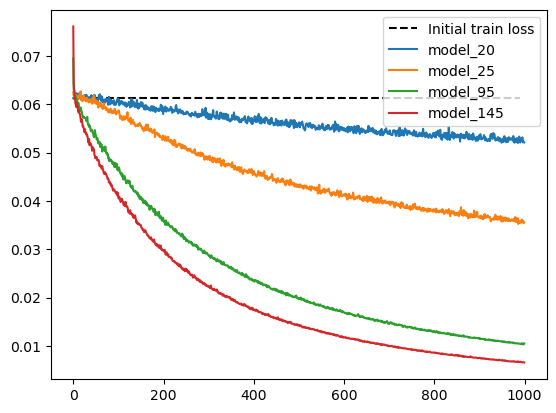

In [6]:
plt.plot(np.arange(0,1000, 10), np.repeat(loss_metrics["model_20"]["train"][0], 100), color="black", linestyle="--", label="Initial train loss")
for i in range(20,150,5):
    if i != 20 and i != 25 and i != 95 and i != 145:
        continue
    plt.plot(loss_metrics[f"model_{i}"]["train"], label=f"model_{i}")

plt.legend()

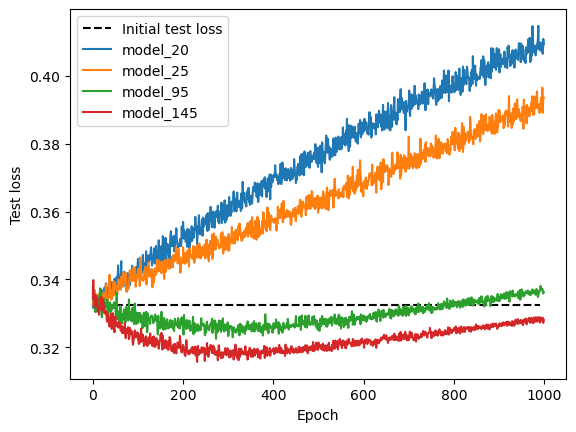

In [7]:
plt.plot(np.arange(0,1000, 10), np.repeat(loss_metrics["model_20"]["test"][0], 100), color="black", linestyle="--", label="Initial test loss")
for i in range(20,150,5):
    if i != 20 and i != 25 and i != 95 and i != 145:
        continue
    plt.plot(loss_metrics[f"model_{i}"]["test"], label=f"model_{i}")
plt.xlabel("Epoch")
plt.ylabel("Test loss")
plt.legend()

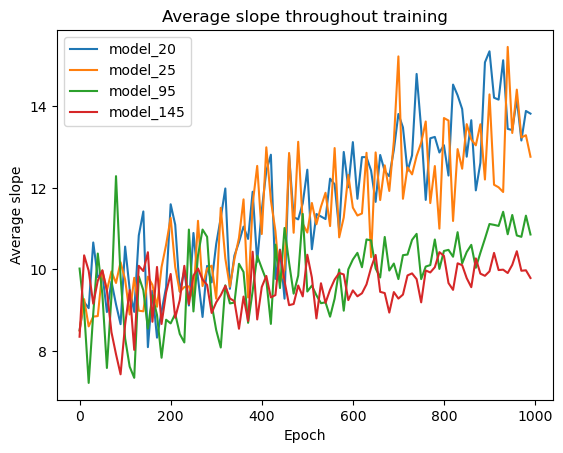

In [8]:
for i in range(20,150,5):
    if i != 20 and i != 25 and i != 95 and i != 145:
        continue
    plt.plot([*range(0,1000, 10)], landscape_metric_store[f"model_{i}"]["slope"], label=f"model_{i}")
plt.xlabel("Epoch")
plt.ylabel("Average slope")
plt.title("Average slope throughout training")
plt.legend()

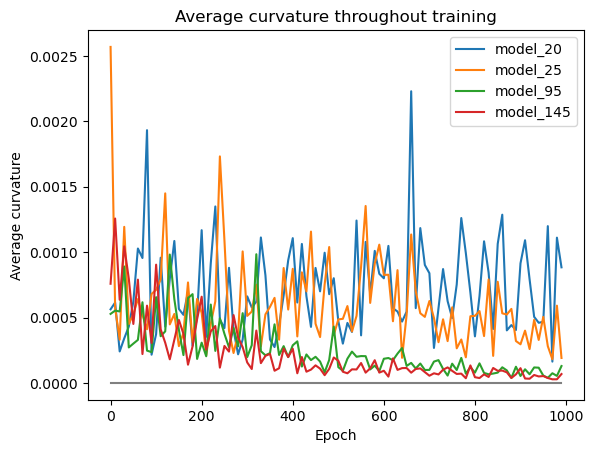

In [9]:
plt.plot(np.arange(0,1000,10), np.zeros(100), color="grey", linestyle="-")
for i in range(20,150,5):
    if i != 20 and i != 25 and i != 95 and i != 145:
        continue
    plt.plot([*range(0,1000, 10)], landscape_metric_store[f"model_{i}"]["curvature"], label=f"model_{i}")
plt.xlabel("Epoch")
plt.ylabel("Average curvature")
plt.title("Average curvature throughout training")
plt.legend()

### Random analysis

In [10]:
slope_means = []
curvature_means = []
for i, (key, value) in enumerate(landscape_metric_store.items()):
    slope_means.append(np.mean(value['slope']))
    curvature_means.append(np.mean(value['curvature']))

# slope_means = [float(i) for i in slope_means]
# slope_means.insert(0, slope_means.pop())
# curvature_means = [float(i) for i in curvature_means]
# curvature_means.insert(0, curvature_means.pop())
# slope_means = np.array(slope_means)
# curvature_means = np.array(curvature_means)

In [11]:
slope_means

[11.59889881849289,
 11.339022295475006,
 11.152976009845734,
 11.22519773721695,
 11.097224838733673,
 10.923430438041686,
 10.80856649875641,
 10.764876596927643,
 10.531128375530242,
 10.204059643745422,
 10.576110413074494,
 10.438594899177552,
 9.809170594215393,
 10.357123908996583,
 10.046425030231475,
 9.83791624546051,
 10.103240141868591,
 9.924377591609955,
 9.870572617053986,
 9.748217120170594,
 9.801858541965485,
 9.596112310886383,
 9.752093386650085,
 9.493854176998138,
 9.533016760349273,
 9.56865752696991]

In [12]:
curvature_means

[0.0007168513023134437,
 0.0005999220999001409,
 0.000506000271798257,
 0.0004712393986847019,
 0.0004296871599217411,
 0.00043512008925972623,
 0.0004548766514744784,
 0.0003544238248741749,
 0.000389211376732419,
 0.00033018585441823233,
 0.00032149834340998494,
 0.0003076438687639893,
 0.00029312424293948425,
 0.00033871152952997364,
 0.00025924677778675685,
 0.0002506712539070577,
 0.00029335096925933615,
 0.00026441837771926655,
 0.0002463166451525467,
 0.00024746469097863155,
 0.00023029044998111204,
 0.0002295930930358736,
 0.0002176651705030963,
 0.00019808273528724386,
 0.0002194273574195904,
 0.00021666431979610934]

In [13]:
slope_ratios = []
curvature_ratios = []
for i in range(len(slope_means)):
    slope_ratios.append(slope_means[i] / slope_means[0])
    curvature_ratios.append(curvature_means[i] / curvature_means[0])

Text(0.5, 1.0, 'Average slope throughout training per model')

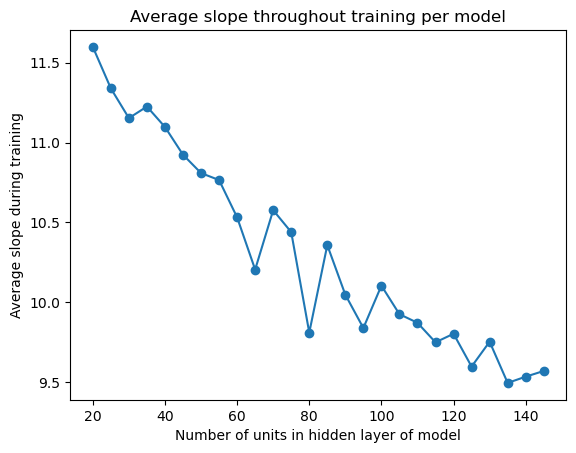

In [14]:
plt.plot([*range(20,150,5)], slope_means, marker="o")
plt.xlabel("Number of units in hidden layer of model")
plt.ylabel("Average slope during training")
plt.title("Average slope throughout training per model")

Text(0.5, 1.0, 'Proportion of start model slope')

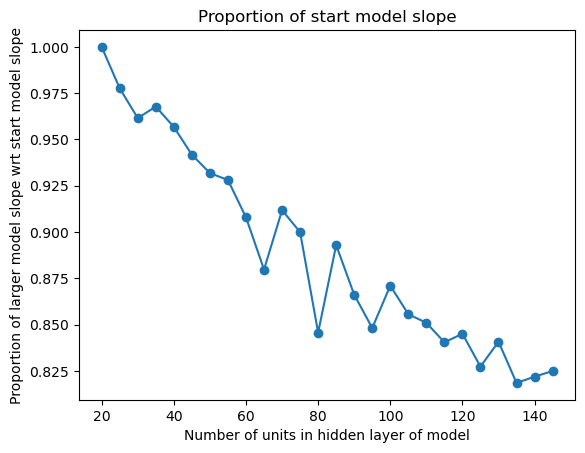

In [16]:
plt.plot([*range(20,150,5)], slope_ratios, marker="o")
plt.xlabel("Number of units in hidden layer of model")
plt.ylabel("Proportion of larger model slope wrt start model slope")
plt.title("Proportion of start model slope")

Text(0.5, 1.0, 'Average curvature throughout training per model')

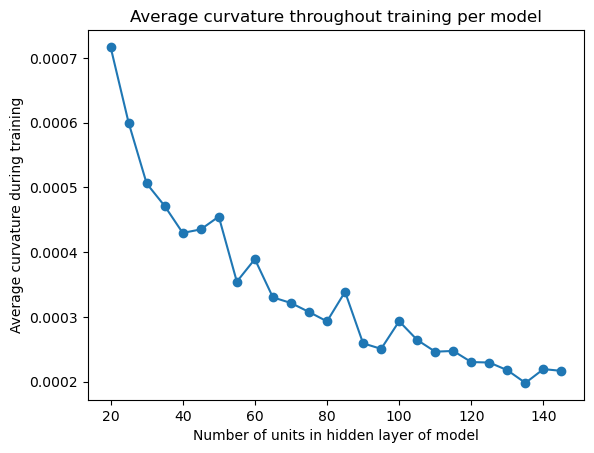

In [17]:
plt.ticklabel_format(useOffset=False, style='plain')
plt.plot([*range(20,150,5)], curvature_means, marker="o")
plt.xlabel("Number of units in hidden layer of model")
plt.ylabel("Average curvature during training")
plt.title("Average curvature throughout training per model")

Text(0.5, 1.0, 'Proportion of start model curvature')

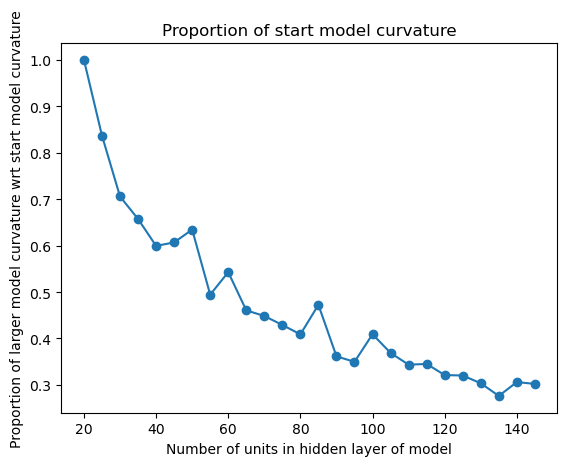

In [18]:
plt.plot([*range(20,150,5)], curvature_ratios , marker="o")
plt.xlabel("Number of units in hidden layer of model")
plt.ylabel("Proportion of larger model curvature wrt start model curvature")
plt.title("Proportion of start model curvature")

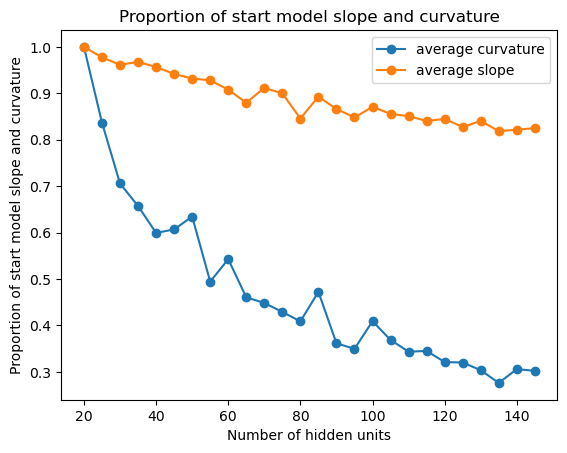

In [19]:
#plt.plot([20,145],[slope_ratios[0], slope_ratios[-1]])
plt.plot([*range(20,150,5)], curvature_ratios, marker="o", label="average curvature")
plt.plot([*range(20,150,5)], slope_ratios, marker="o", label="average slope")
plt.xlabel("Number of hidden units")
plt.ylabel("Proportion of start model slope and curvature")
plt.title("Proportion of start model slope and curvature")
plt.legend()

Text(0.5, 1.0, 'Proportion of start model slope to curvature ratio')

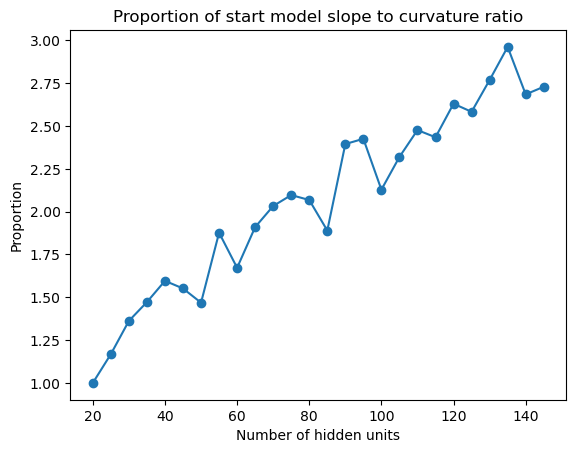

In [20]:
plt.plot([*range(20,150,5)], np.array(slope_ratios) / np.array(curvature_ratios), marker="o")
#plt.plot([*range(20,150,5)], slope_ratios, marker="o", label="average slope")
plt.xlabel("Number of hidden units")
plt.ylabel("Proportion")
plt.title("Proportion of start model slope to curvature ratio")

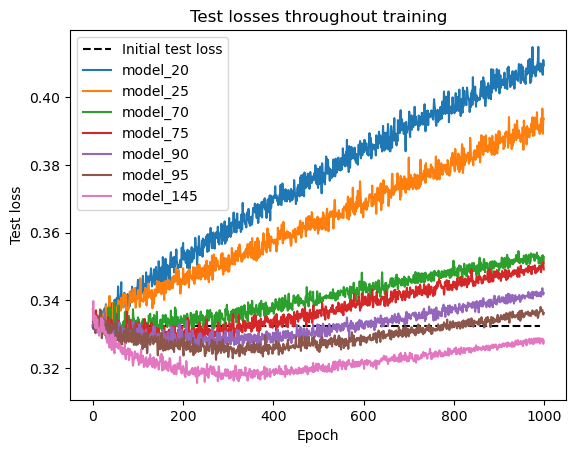

In [21]:
plt.plot(np.arange(0,1000, 10), np.repeat(loss_metrics["model_20"]["test"][0], 100), color="black", linestyle="--", label="Initial test loss")

for i in range(20,150,5):
    if i != 20 and i != 25 and i != 95 and i != 145 and i != 90 and i != 95 and i != 70 and i != 75:
        continue
    plt.plot(loss_metrics[f"model_{i}"]["test"], label=f"model_{i}")
plt.xlabel("Epoch")
plt.ylabel("Test loss")
plt.title("Test losses throughout training")
plt.legend()